# Power Smoothing - LabREI


## Importar bibliotecas e permitir acesso ao drive


In [1]:
running_mode = "jv_notebook"
# running_mode = "colab_online"


In [2]:
# # SÓ RODAR ESSA CÉLULA CASO ESTEJA USANDO COLAB ONLINE!
# %%capture
# !pip install 'OpenDSSDirect.py'
# !pip install dss_python

# from google.colab import drive


In [3]:
import csv
from dss import DSS # type: ignore
import matplotlib.pyplot as plt
import math
import numpy as np
import opendssdirect as DSS1
import os
import pandas as pd
import pickle

from scipy.ndimage import gaussian_filter,gaussian_filter1d


Text = DSS.Text
Circuit = DSS.ActiveCircuit
Solution = DSS.ActiveCircuit.Solution



dir_dados = ''

if running_mode == "jv_notebook":
  #Diretório dos arquivos .csv
  dir_dados += "G:\.shortcut-targets-by-id\\1_LLGSbcAWP4SDEp_n2RAN0OUWSswWgL3\IC João Victor\\2024\Dados_PV_GMU\\"

else:
  dir_dados += '/content/drive/'



<>:24: SyntaxWarning: invalid escape sequence '\.'
<>:24: SyntaxWarning: invalid escape sequence '\.'
C:\Users\joao9\AppData\Local\Temp\ipykernel_24476\4104917869.py:24: SyntaxWarning: invalid escape sequence '\.'
  dir_dados += "G:\.shortcut-targets-by-id\\1_LLGSbcAWP4SDEp_n2RAN0OUWSswWgL3\IC João Victor\\2024\Dados_PV_GMU\\"


In [4]:
# drive.mount(dir_dados)

In [5]:
# Acesso ao Drive

path = ""

if running_mode == "jv_notebook":
  path +="G:\\.shortcut-targets-by-id\\1_LLGSbcAWP4SDEp_n2RAN0OUWSswWgL3\IC João Victor\\2024\\Notebooks\\"

else:
  dir_dados += "Shareddrives/Projeto_ICFAPESP_Joao_Victor_Gomes_Carneiro/"
# name = "ModelagemLabREI.dss"
opendssmodel = "ModelagemLabREI.dss"

# Definições da MatPlotLib
plt.close('all')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['cmr10']
plt.rcParams['axes.unicode_minus'] = False


# Definições do BESS
Pmin=0.320
BESS_P_MAX = 5
BESS_C_MAX = 12
SOC_MIN = 0.1 # 10%
SOC_MAX = 0.9 # 90%
BESS_E_MIN = BESS_C_MAX * SOC_MIN
BESS_E_MAX = BESS_C_MAX * SOC_MAX

# Definições NumPy
np.random.seed(185)

# Definições Pandas
pd.options.display.float_format = "{:,.4f}".format
print(BESS_P_MAX)

5


<>:6: SyntaxWarning: invalid escape sequence '\I'
<>:6: SyntaxWarning: invalid escape sequence '\I'
C:\Users\joao9\AppData\Local\Temp\ipykernel_24476\3585208674.py:6: SyntaxWarning: invalid escape sequence '\I'
  path +="G:\\.shortcut-targets-by-id\\1_LLGSbcAWP4SDEp_n2RAN0OUWSswWgL3\IC João Victor\\2024\\Notebooks\\"


Definições da Potência de Carregamento, timestep e quantidade de horas

In [6]:
quant_horas = 24
intervalo=5 #min
loop = (quant_horas*60)/intervalo

BESS_E_MAX_Intervalo = BESS_E_MAX*(intervalo/60)

loop = int(loop)
print(loop)
print(BESS_E_MAX)

288
10.8


# Experimento 1 - operação da bateria sem algoritmo


In [7]:
# PowerP1 = 3
# perfil_carga1 = np.random.rand(2,loop) # 2 linhas de 96 pontos(15 em 15 min)
# perfil_carga1[1] = perfil_carga1[1]/10
# print(perfil_carga1)


# PowerP2=4
# perfil_carga2 = np.random.rand(2,loop) # 2 linhas de 1440 pontos
# perfil_carga2[1] = perfil_carga2[1]/10
# print(perfil_carga2)

#Utilizando os dados de carga do Juan
dir_load = ""
if running_mode == "jv_notebook":
  dir_dados = "G:\Drives compartilhados\Projeto_ICFAPESP_Joao_Victor_Gomes_Carneiro\Dados_PV_GMU\\"
else:
  dir_load += "Dados_PV_GMU/"

dados_load = dir_dados + 'household_power_consumption_5min.csv'

print(dados_load)

load = pd.read_csv(dados_load,delimiter=';')

P = load['Global_active_power'][0:loop].values
Q = load['Global_reactive_power'][0:loop].values

PowerP2=4
perfil_carga2 = np.array((P,Q)) # 2 linhas de 288 pontos
# print(perfil_carga2)
# print(perfil_carga2.shape)


# perfil_pv= np.zeros((2,loop))
# perfil_pv[0] = np.random.rand(loop)

perfil_bess = np.zeros((2,loop))
# print(perfil_bess)
# perfil_bess[0][0]=np.random.random()


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\joao9\AppData\Local\Temp\ipykernel_24476\4210992274.py:15: SyntaxWarning: invalid escape sequence '\D'
  dir_dados = "G:\Drives compartilhados\Projeto_ICFAPESP_Joao_Victor_Gomes_Carneiro\Dados_PV_GMU\\"


G:\Drives compartilhados\Projeto_ICFAPESP_Joao_Victor_Gomes_Carneiro\Dados_PV_GMU\household_power_consumption_5min.csv


Criando os dados de Previsão e reais para operação

In [8]:
#Dados de Geração Fotovoltaica

#Acessando os dados de geração Reais do GMU

geracao_GMU = dir_dados + 'df_unicamp_2022.csv'
geracao_Juan = dir_dados  + 'pv_unicamp_5min.csv'

dados = pd.read_csv(geracao_Juan,delimiter=';')
# dados_power = pd.read_csv(geracao_GMU,delimiter=';',usecols=['power'],decimal='.',thousands=',',dtype=np.float64)

#Extração dos dados de apenas 1 dia
power = dados['power'][:loop]
# power = power/276.5 # 276.5 é a potência máxima em kW de geração do GMU
# display(power)

#Dados que serão usados como os dados previsto de geração fotovoltatica
pv_prev= np.zeros((2,loop))
pv_prev[0] = power.values
# print('PV_prev\n',pv_prev[0])

# pv_prev= perfil_pv
# print('PV_prev\n',pv_prev[0])

#Função para variar +-30% os valores de potência
def variar_elemento(elemento):
    variacao = np.random.uniform(-0.3, 0.3)  # Gera um número aleatório entre -0.3 e 0.3
    return elemento * (1 + variacao)

#Dados que serão utilizados como dados de geração reais

PowerPV=6 #Potência total dos módulos
pv_real = np.zeros((2,loop))
pv_real[0]= np.array([variar_elemento(e) for e in pv_prev[0]])
# pv_real[0]= power.values
# print('PV_real\n',pv_real[0])




Definindo os componentes do circuito

In [9]:
loads = {
    # 'loadbus13':{
    #     'bus': 'bus_013.1.2.3',
    #     'phases': 3,
    #     'voltage': 0.22,
    #     'power': PowerP1,
    #     'profile': perfil_carga1,
    #     'conn': 'wye'
    # },
    'loadbus021':{
        'bus': 'bus_021.1.2.3',
        'phases': 3,
        'voltage': 0.22,
        'power': PowerP2,
        'profile': perfil_carga2,
        'conn': 'wye'
    },
}
#Adicionando a Geração e o BESS próximo à carga
distgen = {
    'pvbus022':{
        'bus': 'bus_022.1.2.3',
        'phases': 3,
        'voltage': 0.22,
        'power': PowerPV,
        'profile': pv_real,
        'conn': 'delta',
    },
}

distbess = {
    'bessbus023':{
      'bus': 'bus_023.1.2.3',
      'phases': 3,
      'voltage': 0.22,
      'power': BESS_P_MAX,
      'profile': perfil_bess,
      'conn': 'delta'
    },
}

In [10]:
def add_load(i, name, bus, phases, kV, kW, profile, model=8, classe=1, vminpu=0.92, ZIPV=(0.5, 0, 0.5, 1, 0, 0, 0.5)):
  # Conectada em estrela
  new_load = f"New Load.{name} bus1={bus} Phases={phases} kV={kV} kW={kW*profile[0][i]:.2f} kVAr={kW*profile[1][i]:.2f} Model={model} Class={classe} Vminpu={vminpu} ZIPV={ZIPV}"

  return new_load

def add_gd(i, name, bus, phases, conn, kV, kW, profile, model=1, vminpu=0.92):
  new_gd = f"New Generator.{name} bus1={bus} Phases={phases} Conn={conn} kV={kV} kW={kW*profile[0][i]:.2f} kVAr={kW*profile[1][i]:.2f} Model={model} Vminpu={vminpu}"

  return new_gd

# def add_mon(monitors, element, terminal):
#   new_mon = '\n\n'
#   for i, name in enumerate(monitors):
#     new_mon = new_mon + f"New Monitor.mon_{name}_vi element={element[i]} Terminal={terminal[i]} mode=0 ppolar=no\n"
#     new_mon = new_mon + f"New Monitor.mon_{name}_pq element={element[i]} Terminal={terminal[i]} mode=1 ppolar=no\n"
#   return new_mon
# New Monitor.mon_ipe_vi element=Transformer._oh_566670641_566670640_ Terminal=2 mode=0 ppolar=no
# New Monitor.mon_ipe_pq element=Transformer._oh_566670641_566670640_ Terminal=1 mode=1 ppolar=no


In [11]:
def add_bess(i, name, bus, phases, conn, kV, kW, profile, model=1, vminpu=0.92):
  # print(i, name, bus, phases, conn, kV, kW, profile, model, vminpu)
  # Potência positiva: carrega,
  # Potência negativa: descarrega

  new_bess = f"New Load.{name} bus1={bus} Phases={phases} Conn={conn} kV={kV} kW={kW*profile[0][i]:.2f} kVAr={kW*profile[1][i]:.2f} Model={model} Vminpu={vminpu} "

  return new_bess


In [12]:
def get_dist_power(column, i, power_df, loads, distgen, distbess):

  bus_to_search = []
  for load in loads:    bus_to_search.append([load, loads[load]['bus'].split('.', 1)[0], loads[load]['power']*loads[load]['profile'][0][i], loads[load]['power']*loads[load]['profile'][1][i]])
  for gen in distgen:   bus_to_search.append([gen,  distgen[gen]['bus'].split('.', 1)[0], distgen[gen]['power']*distgen[gen]['profile'][0][i], distgen[gen]['power']*distgen[gen]['profile'][1][i]])
  for bess in distbess: bus_to_search.append([bess, distbess[bess]['bus'].split('.', 1)[0], distbess[bess]['power']*distbess[bess]['profile'][0][i], distbess[bess]['power']*distbess[bess]['profile'][1][i]])

  # print(bus_to_search)

  node_power_df = pd.DataFrame(columns = column)

  for bus in bus_to_search:
      # Procurar os valores de potência dos barramentos das cargas e geração distribuída
      # print('bus')
      # print(bus[0], bus[1])

      flow_in  = power_df.index[power_df['bus_2'] == bus[1]].tolist()
      # print('flow in\n',flow_in)
      # Tratar flow in para ver se tem algum nó

      flow_out = power_df.index[power_df['bus_1'] == bus[1]].tolist()
      # print('flow out\n',flow_out)
      # Tratar flow out para ver se tem algum nó

      # print(flow_in, flow_out)
      P_in, P_out = 0, 0
      if (flow_in != []): P_in = power_df.loc[flow_in[-1], 'P']
      if (flow_out != []):P_out = power_df.loc[flow_out[0], 'P']
      P_node = P_in + P_out

      Q_in, Q_out = 0, 0
      if (flow_in != []): Q_in = power_df.loc[flow_in[-1], 'Q']
      if (flow_out != []):Q_out = power_df.loc[flow_out[0], 'Q']
      Q_node = Q_in + Q_out



      node_power_df = pd.concat([node_power_df, pd.DataFrame([[i, bus[0], P_node, Q_node, bus[2], bus[3]]], columns=column)])

      # print(bus[0], '// P: ', P_node, '// Q: ', Q_node)

  # display(node_power_df)
  return node_power_df



In [13]:
opendssmodel = "ModelagemLabREI.dss"

if running_mode == "colab_online":
  opendssmodel = "/content/drive/Shareddrives/Projeto_ICFAPESP_Joao_Victor_Gomes_Carneiro/Scripts/Notebooks/"+ opendssmodel

In [14]:
opendssmodel

'ModelagemLabREI.dss'

In [20]:
DSS.ClearAll()
DSS.Start(0)
# print(path, name)

Text.Command = "Clear"
# Text.Command = f"Compile {opendssmodel}"

# bus_names = np.array(DSS1.Circuit.AllBusNames())
# print(bus_names)

In [21]:
Text.Command = "New Line.Line_002_load bus1=bus_002 bus2=bus_021 Length=0.01 Units=m Geometry=Geometria phases=3"


DSSException: (#265) You Must Create a circuit first: "new circuit.yourcktname"

In [19]:
bus_names = np.array(DSS1.Circuit.AllBusNames())
print(bus_names)

['bus_001' 'bus_002' 'bus_003' 'bus_004' 'bus_005' 'bus_006' 'bus_007'
 'bus_008' 'bus_009' 'bus_010' 'bus_011' 'bus_012' 'bus_013']


Operação sem o BESS

In [ ]:
bus_names = bus_names.reshape(bus_names.shape[0], 1)
# print(bus_names)

# column_voltages = ['bus', 'timestep', 'VA', 'VB', 'VC']
# voltages_df = pd.DataFrame(columns = column_voltages)

# column_power = ['timestep', 'line', 'bus_1', 'bus_2', 'P', 'Q', 'P_a', 'Q_a', 'P_b', 'Q_b', 'P_c', 'Q_c']
column_power = ['timestep', 'line', 'bus_1', 'bus_2', 'P', 'Q']
power_df = pd.DataFrame(columns = column_power)

column_node_power = ['timestep', 'name', 'P', 'Q', 'P_profile', 'Q_profile']
node_power_df1 = pd.DataFrame(columns=column_node_power)




for timestep in range(loop-1):
  new_command = ''
  for load in loads:
    new_command = new_command + '\n' + add_load(timestep, load, loads[load]['bus'], loads[load]['phases'], 
    loads[load]['voltage'], loads[load]['power'], loads[load]['profile'])

  for gen in distgen:
    new_command = new_command + '\n' + add_gd(timestep, gen, distgen[gen]['bus'], distgen[gen]['phases'], 
    distgen[gen]['conn'], distgen[gen]['voltage'], distgen[gen]['power'], distgen[gen]['profile'])
    
  for bess in distbess:
    new_command = new_command + '\n' + add_bess(timestep, bess, distbess[bess]['bus'], distbess[bess]['phases'], 
    distbess[bess]['conn'], distbess[bess]['voltage'], distbess[bess]['power'], distbess[bess]['profile'])
  # print(new_command)

  DSS.ClearAll()
  DSS.Start(0)
  # print(path, name)

  DSS("Clear")
  DSS(f"Compile {opendssmodel}")
  DSS(new_command)

  DSS("Set VoltageBases = [.22]")
  DSS("CalcVoltageBases")
  DSS("Set maxiterations = 500")
  DSS('set mode = snap')
  DSS("Solve")

  # print(DSS1.Circuit.AllBusVMag())
  # voltages = np.array(DSS1.Circuit.AllBusVMag()).reshape(bus_names.shape[0], 3)

  # Voltages DataFrame
  # data_to_append = pd.DataFrame(np.hstack((bus_names, np.full((bus_names.shape[0],1), i), voltages)), columns=column_voltages)
  # voltages_df = pd.concat([voltages_df, data_to_append])

  # Power Flow to DataFrame
  power = np.array(DSS1.PDElements.AllPowers())
  # print(power)
  power = power.reshape((-1, 6))
  # print(power)
  power = pd.DataFrame(power, columns=['P_a', 'Q_a', 'P_b', 'Q_b', 'P_c', 'Q_c'])
  # display(power)


  # Create new column that contains sum of specific columns
  power['P'] = power[['P_a', 'P_b', 'P_c']].sum(axis=1)
  power['Q'] = power[['Q_a', 'Q_b', 'Q_c']].sum(axis=1)

  # Get the index for each row of the Data Frame
  power_flow_index = []
  for line in DSS1.Lines:
      power_flow_index.append([timestep, line.Name(), line.Bus1(), line.Bus2()])
      power_flow_index.append([timestep, line.Name(), line.Bus1(), line.Bus2()])
  # print(power_flow_index)

  power[['timestep', 'line', 'bus_1', 'bus_2']] = power_flow_index
  # display(power)
  power_df = pd.concat([power_df, power])
  # display(power_df)


  # Get distributed generation power
  node_power = get_dist_power(column_node_power, timestep, power, loads, distgen, distbess)

  # display(node_power)

  # Add Grid and Losses power to DataFrame
  # The last "Power Balance" of the system, to be used in the smoothing algorithm.
  node_power = pd.concat([node_power, pd.DataFrame([[timestep, 'grid', -DSS1.Circuit.TotalPower()[0], -DSS1.Circuit.TotalPower()[1], 0, 0]], columns=column_node_power)])
  node_power = pd.concat([node_power, pd.DataFrame([[timestep, 'losses', DSS1.Circuit.Losses()[0]/1000, DSS1.Circuit.Losses()[1]/1000, 0, 0]], columns=column_node_power)])


  node_power_df1 = pd.concat([node_power_df1, node_power])

C:\Users\joao9\AppData\Local\Temp\ipykernel_546020\259696130.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  power_df = pd.concat([power_df, power])
C:\Users\joao9\AppData\Local\Temp\ipykernel_546020\3004391001.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  node_power_df = pd.concat([node_power_df, pd.DataFrame([[i, bus[0], P_node, Q_node, bus[2], bus[3]]], columns=column)])
C:\Users\joao9\AppData\Local\Temp\ipykernel_546020\259696130.py:85: FutureWarning: The behavior of DataFrame co

Plotando a demanda de Potência sem Operação da Bateria

In [ ]:
carga_kw1_SB = []
circuit_kw1_SB =[]
pv6_kw1_SB =[]
bateria_kw1_SB = []
losses_kw1_SB = []
for timestep in range(loop-1):
    # Filtrar as linhas onde `timestep` é o atual e `name` é `loadbus13` ou `loadbus02`
    filtered_load = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['loadbus021']))]
    filtered_grid = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['grid']))]
    filtered_pv = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['pvbus022']))]
    filtered_bes = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['bessbus023']))]
    filtered_losses = node_power_df1[(node_power_df1['timestep'] == timestep) & (node_power_df1['name'].isin(['losses']))]

    # Acessar a coluna `P` dessas linhas
    p_values = sum(filtered_load['P'].values)
    carga_kw1_SB.append(p_values)

    grid_values = filtered_grid['P'].values[0]
    circuit_kw1_SB.append(grid_values)

    pv_values = filtered_pv['P'].values[0]
    pv6_kw1_SB.append(pv_values)

    # bess_values = filtered_bes['P'].values[0]
    # bateria_kw1.append(bess_values)

    losses_values = filtered_losses['P'].values[0]
    losses_kw1_SB.append(losses_values)



carga_kw_SB = np.array(carga_kw1_SB)
bateria_kw = np.array(bateria_kw1_SB)
pv6_kw_SB = -np.array(pv6_kw1_SB)
circuit_kw_SB = -np.array(circuit_kw1_SB)
losses_kw = np.array(losses_kw1_SB)

Dmed_SB = np.mean(circuit_kw_SB)
Dmax_SB = np.max(circuit_kw_SB)
print('Demanda Média',Dmed_SB)
print('Demanda Máxima',Dmax_SB)

Demanda Média 0.03310921949907841
Demanda Máxima 4.912780152398187


Curva de Demanda Sem Operação BESS

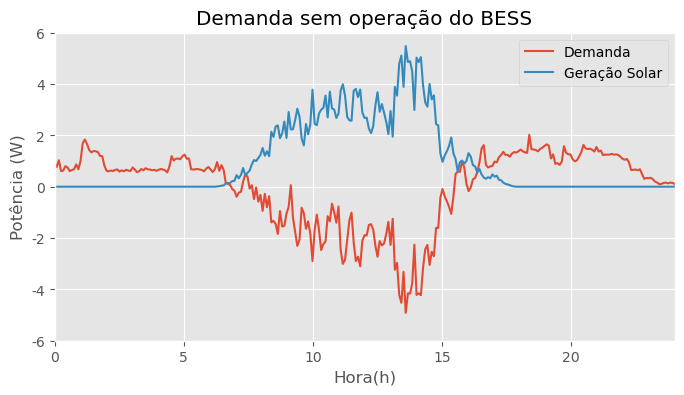

In [ ]:
horas = np.linspace(0,24,loop-1)
# plt.plot(horas,carga_kw-pv6_kw,label='Demand')
plt.plot(horas, -circuit_kw_SB,label='Demanda')
# plt.plot(horas,gaussian_filter(circuit_kw,6),linestyle = '--',label='Gaussian-Filter')
plt.plot(horas, -pv6_kw_SB,label='Geração Solar')

# plt.plot(horas,losses_kw,label='Losses')

plt.title('Demanda sem operação do BESS')
plt.xlabel('Hora(h)')
plt.ylabel('Potência (W)')
plt.ylim(-6,6)
plt.xlim(0,24)
plt.legend(loc=1)


In [ ]:
# #______________________________________________________________________________#
# #                         FUNÇÃO - OPERAÇÃO BATERIA                            #
# #______________________________________________________________________________#

def operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_ant,pv_med,PVprev,alpha,bheta,Soc,sigma):
    global BESS_E_MAX,BESS_E_MIN,BESS_P_MAX,BESS_C_MAX,intervalo
   #  print(f'Load[0] {load_atual: .2f} --- Load[-1] {load_ant: .2f} --- Load[1] {load_prev: .2f}')
   #  print(f'  PV[0] {pv_atual: .2f}   ---   PV[-1] {pv_ant: .2f} ---   PV[1] {PVprev: .2f} --- PV[med] {pv_med: .2f}')

    pv_prev = (alpha * PVprev) + (bheta * pv_med) # Ponderação da previsão de geração
    #  print(pv_prev)

    pot_prev = load_prev-pv_prev
    #  print(pot_prev)

    vec_gauss = [load_ant-pv_ant,load_atual-pv_atual,pot_prev] # Vetor a ser aplicado o Filtro Gaussiano
    gauss_value = gaussian_filter1d(vec_gauss,sigma=sigma,radius=1)[1] #Valor a ser utilizado para definir a potência do BESS

    # PBessSeg = pbess_atual+((load_atual-pv_atual)-gauss_value) # Valor em kW
    PBessSeg = ((load_atual-pv_atual)-gauss_value)
   #  print(f'PBessAtual: {pbess_atual}, PBessSeg {PBessSeg: .2f}')

    Bess_E_atual = Soc*BESS_C_MAX # Energia da bateria no instante atual(kWh)
    Bess_E_seg = Bess_E_atual + (PBessSeg*(intervalo/60))
   #  print(f'EBessAtual: {Bess_E_atual: .2f}, Bess_E_seg {Bess_E_seg: .2f}, SoC seg: {Bess_E_seg/BESS_C_MAX: .2f}')

    if PBessSeg> 0 : #Bateria vai carregar

      if PBessSeg>BESS_P_MAX: #Potência seguinte maior que a maxima
         Pseg = BESS_P_MAX
         Bess_E_seg = Bess_E_atual+Pseg*(intervalo/60) # Energia da bateria no instante seguinte

         if Bess_E_seg>BESS_E_MAX: #Energia seguinte maior que máxima permitida
            Pseg = (BESS_E_MAX-Bess_E_atual)/(intervalo/60) #carrega para atingir 90% da capacidade
            if Pseg>BESS_P_MAX:
               Pseg = BESS_P_MAX
               # print('Aqui1')
               return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]
            else:
               # print('Aqui2')
               return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]

         else: #Carrega com a potência máxima
            # print('Aqui3')
            return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]
      else: # Bateria vai descarregar
         Pseg = PBessSeg
         Bess_E_seg = Bess_E_atual + Pseg*(intervalo/60) # Energia da bateria no instante seguinte

         if Bess_E_seg>BESS_E_MAX: #Energia seguinte maior que máxima permitida
            Pseg = (BESS_E_MAX-Bess_E_atual)/(intervalo/60) #carrega para atingir 90% da capacidade
            if Pseg>BESS_P_MAX:
               Pseg = BESS_P_MAX
               # print('Aqui4')
               return [Pseg, Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]
            else:
               # print('Aqui5')
               return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]

         else: #Carrega com a potência seguinte definida
            # print('Aqui6')
            return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]

    else: # Bateria vai descarregar
      if PBessSeg<-BESS_P_MAX: #Potência seguinte maior que a maxima
         Pseg = -BESS_P_MAX
         Bess_E_seg = Bess_E_atual+Pseg*(intervalo/60) # Energia da bateria no instante seguinte

         if Bess_E_seg<BESS_E_MIN: #Energia seguinte menor que a máxima permitida
            Pseg = (BESS_E_MIN-Bess_E_atual)/(intervalo/60) #descarregar para atingir no máximo 10% da capacidade
            if Pseg<-BESS_P_MAX:
               Pseg = -BESS_P_MAX
               # print('Aqui7')
               return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]
            else:
               # print('Aqui8')
               return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]

         else: #Descarrega com a potência máxima
            # print('Aqui9')
            return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX),gauss_value]
      else:
          Pseg = PBessSeg
          Bess_E_seg = Bess_E_atual+(Pseg*(intervalo/60)) # Energia da bateria no instante seguinte

          if Bess_E_seg<BESS_E_MIN: #Energia seguinte menor que a minima permitida
              Pseg = (BESS_E_MIN-Bess_E_atual)/(intervalo/60) #descarrega para atingir no máximo 10% da capacidade
              if Pseg<-BESS_P_MAX:
                Pseg = -BESS_P_MAX
               #  print('Aqui10')
                return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX), gauss_value]
              else:
               #  print('Aqui11')
                return [Pseg,Soc + (Pseg*(intervalo/60)/BESS_C_MAX), gauss_value]

          else: #Descarrega com a potência máxima
            #   print('Aqui12')
              return [Pseg, Soc + (Pseg*(intervalo/60)/BESS_C_MAX), gauss_value]


Operação com o BESS

In [ ]:
bus_names = bus_names.reshape(bus_names.shape[0], 1)
# print(bus_names)

# column_voltages = ['bus', 'timestep', 'VA', 'VB', 'VC']
# voltages_df = pd.DataFrame(columns = column_voltages)

# column_power = ['timestep', 'line', 'bus_1', 'bus_2', 'P', 'Q', 'P_a', 'Q_a', 'P_b', 'Q_b', 'P_c', 'Q_c']
column_power = ['timestep', 'line', 'bus_1', 'bus_2', 'P', 'Q']
power_df = pd.DataFrame(columns = column_power)

column_node_power = ['timestep', 'name', 'P', 'Q', 'P_profile', 'Q_profile']
node_power_df = pd.DataFrame(columns=column_node_power)

colum_luiza = ['timestep', 'load_atual', 'load_ant', 'load_prev', 'pv_atual','pv_ant', 'pv_med', 'pv_prev', 'pbess_atual','pbes_seg', 'gauss', 'Soc']
dados_luiza = pd.DataFrame(columns=colum_luiza)

#Valores Iniciais de operação
sigma = 45
alpha = 0.5
bheta = 0.5
Soc = 0.5
Lista_Soc = np.zeros((1,loop))
Lista_Soc[0][0] = Soc

for timestep in range(loop-1):
# for timestep in range(60):
  new_command = ''
  for load in loads:
    new_command = new_command + '\n' +add_load(timestep, load, loads[load]['bus'], loads[load]['phases'], loads[load]['voltage'], loads[load]['power'], loads[load]['profile'])
  for gen in distgen:
    new_command = new_command + '\n' + add_gd(timestep, gen, distgen[gen]['bus'], distgen[gen]['phases'], distgen[gen]['conn'], distgen[gen]['voltage'], distgen[gen]['power'], distgen[gen]['profile'])
  for bess in distbess:
    new_command = new_command + '\n' + add_bess(timestep, bess, distbess[bess]['bus'], distbess[bess]['phases'], distbess[bess]['conn'], distbess[bess]['voltage'], distbess[bess]['power'], distbess[bess]['profile'])
  # print(new_command)

  DSS.ClearAll()
  DSS.Start(0)
  # print(path, name)

  DSS("Clear")
  DSS(f"Compile {opendssmodel}")
  DSS(new_command)

  DSS("Set VoltageBases = [.22]")
  DSS("CalcVoltageBases")
  DSS("Set maxiterations = 500")
  DSS('set mode = snap')
  DSS("Solve")


  # Power Flow to DataFrame
  power = np.array(DSS1.PDElements.AllPowers())
  # print(power)
  power = power.reshape((-1, 6))
  # print(power)
  power = pd.DataFrame(power, columns=['P_a', 'Q_a', 'P_b', 'Q_b', 'P_c', 'Q_c'])
  # display(power)


  # Create new column that contains sum of specific columns
  power['P'] = power[['P_a', 'P_b', 'P_c']].sum(axis=1)
  power['Q'] = power[['Q_a', 'Q_b', 'Q_c']].sum(axis=1)

  # Get the index for each row of the Data Frame
  power_flow_index = []
  for line in DSS1.Lines:
      power_flow_index.append([timestep, line.Name(), line.Bus1(), line.Bus2()])
      power_flow_index.append([timestep, line.Name(), line.Bus1(), line.Bus2()])
  # print(power_flow_index)

  power[['timestep', 'line', 'bus_1', 'bus_2']] = power_flow_index
  # display(power)
  power_df = pd.concat([power_df, power])
  # display(power_df)


  # Get distributed generation power
  node_power = get_dist_power(column_node_power, timestep, power, loads, distgen, distbess)

  # display(node_power)

  # Add Grid and Losses power to DataFrame
  # The last "Power Balance" of the system, to be used in the smoothing algorithm.
  node_power = pd.concat([node_power, pd.DataFrame([[timestep, 'grid', -DSS1.Circuit.TotalPower()[0], -DSS1.Circuit.TotalPower()[1], 0, 0]], columns=column_node_power)],ignore_index=True)
  node_power = pd.concat([node_power, pd.DataFrame([[timestep, 'losses', DSS1.Circuit.Losses()[0]/1000, DSS1.Circuit.Losses()[1]/1000, 0, 0]], columns=column_node_power)],ignore_index=True)



  node_power_df = pd.concat([node_power_df, node_power])


  if timestep>2:

    #Dados De Input da funcao do BESS
    load_atual = perfil_carga2[0][timestep]*PowerP2
    load_ant = perfil_carga2[0][timestep-1]*PowerP2
    # print(timestep,load_ant)
    load_prev = np.mean(perfil_carga2[0][timestep:timestep-3:-1]*PowerP2)
    # print(perfil_carga2[0][timestep-1:timestep-4:-1])
    pv_atual = pv_real[0][timestep]*PowerPV
    # print(pv_real[0][timestep-1:timestep-4:-1])
    pv_med = np.mean(pv_real[0][timestep:timestep-3:-1]*PowerPV)
    pv_ant = pv_real[0][timestep-1]*PowerPV
    # print(timestep,pv_ant)
    PV_prev = pv_prev[0][timestep+1]*PowerPV
    pbess_atual = perfil_bess[0][timestep]*BESS_P_MAX
    # print(f'timestep: {timestep}, PBessatual: {pbess_atual}')

    # print('Timestep',timestep)
    # print('CargaAtual',load_atual)
    # print('LoadAnt',load_ant)
    # print('LoadPrev',load_prev)
    # print(perfil_carga2[0][timestep:timestep-3:-1]*PowerP2)
    # print('GeracPrev',PV_prev)
    # print('PvAtual',pv_atual)
    # print('PvPrev',pv_med)
    # print('PvAnt',pv_ant)
    # print('PbesAtual',pbess_atual)
    # print('')


    #Dados retornados pela funcao para definir o instante seguinte
    # print(operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_med,pv_ant,PV_prev,pbess_ant,alpha,bheta,Soc,sigma))

    ## Ponto de atenção ##
    bess_op = operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_ant,pv_med,PV_prev,alpha,bheta,Soc,sigma)

    PBseg = bess_op[0]/BESS_P_MAX
    Soc = bess_op[1]
    gauss = bess_op[2]

    # print(f'PBSeg: {PBseg:.2f} --- PBSeg x PMAX {PBseg*BESS_P_MAX: .2F} ---  Soc: {Soc: .2f} --- gauss: {gauss:.2f}')

    # PBseg= operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_ant,pv_med,PV_prev,pbess_atual,alpha,bheta,Soc,sigma)[0]/BESS_P_MAX
    # Soc= operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_ant,pv_med,PV_prev,pbess_atual,alpha,bheta,Soc,sigma)[1]
    # gauss = operacao_bess(load_atual,load_ant,load_prev,pv_atual,pv_ant,pv_med,PV_prev,pbess_atual,alpha,bheta,Soc,sigma)[2]


    # print(f'PBseg {PBseg}')
    # print(f'SocSeg {Soc}')

    #Atualiza a potência de operação do BESS no instante seguinte
    perfil_bess[0][timestep+1] = PBseg
    Lista_Soc[0][timestep+1] = Soc

    # print(perfil_bess[0][timestep+1])
    # print(perfil_bess[0][timestep])

    #Adicionando os dados para Análise
    new_line = pd.DataFrame({'timestep':[timestep],'load_atual':[load_atual],'load_ant':[load_ant],'load_prev':[load_prev],'pv_atual':[pv_atual],'pv_med':[pv_med],
                             'pv_ant':[pv_ant], 'pv_prev':[PV_prev],'pbess_atual':[pbess_atual],'pbes_seg':[PBseg*BESS_P_MAX],'gauss':[gauss], 'Soc':[Soc]})

    dados_luiza = pd.concat([dados_luiza,new_line],ignore_index=True)

  else:
    if timestep>0:

      #Dados De Input da funcao do BESS
      load_atual = perfil_carga2[0][timestep]*PowerP2
      load_ant = perfil_carga2[0][timestep-1]*PowerP2
      pv_atual = pv_real[0][timestep]*PowerPV
      pv_med = np.mean(pv_real[0][timestep:timestep-3:-1]*PowerPV)
      pv_ant = pv_real[0][timestep-1]*PowerPV
      pbess_atual = perfil_bess[0][timestep]*BESS_P_MAX

      new_line = pd.DataFrame({'timestep':[timestep],'load_atual':[load_atual],'load_ant':[load_ant],'load_prev':[0],'pv_atual':[pv_atual],'pv_med':[0],
                             'pv_ant':[pv_ant], 'pv_prev':[0],'pbess_atual':[pbess_atual],'pbes_seg':[0],'gauss':[0], 'Soc':[Soc]})

      dados_luiza = pd.concat([dados_luiza,new_line],ignore_index=True)

      Lista_Soc[0][timestep+1] = Soc
      continue

    else:

      #Dados De Input da funcao do BESS
      load_atual = perfil_carga2[0][timestep]*PowerP2
      pv_atual = pv_real[0][timestep]*PowerPV
      pv_med = np.mean(pv_real[0][timestep:timestep-3:-1]*PowerPV)
      pv_ant = pv_real[0][timestep-1]*PowerPV
      pbess_atual = perfil_bess[0][timestep]*BESS_P_MAX

      new_line = pd.DataFrame({'timestep':[timestep],'load_atual':[load_atual],'load_ant':[0],'load_prev':[0],'pv_atual':[pv_atual],'pv_med':[0],
                             'pv_ant':[0], 'pv_prev':[0],'pbess_atual':[pbess_atual],'pbes_seg':[0],'gauss':[0], 'Soc':[Soc]})

      dados_luiza = pd.concat([dados_luiza,new_line],ignore_index=True)

      Lista_Soc[0][timestep+1] = Soc





In [ ]:
# # display(node_power_df)
# print(node_power_df.index)
# node_power_df.reset_index(inplace=True)
# # display(node_power_df)

Plotando a demanda de Potência Com Operação da Bateria

In [ ]:
carga_kw1 = []
circuit_kw1 =[]
pv6_kw1 =[]
bateria_kw1 = []
losses_kw1 = []
for timestep in range(loop-1): #Um step a menos pra não dar erro na previsão

    # Filtrar as linhas onde `timestep` é o atual e `name` é `loadbus13` ou `loadbus02`
    filtered_load = node_power_df[(node_power_df['timestep'] == timestep) & (node_power_df['name'].isin(['loadbus021']))]
    filtered_grid = node_power_df[(node_power_df['timestep'] == timestep) & (node_power_df['name'].isin(['grid']))]
    filtered_pv = node_power_df[(node_power_df['timestep'] == timestep) & (node_power_df['name'].isin(['pvbus022']))]
    filtered_bes = node_power_df[(node_power_df['timestep'] == timestep) & (node_power_df['name'].isin(['bessbus023']))]
    filtered_losses = node_power_df[(node_power_df['timestep'] == timestep) & (node_power_df['name'].isin(['losses']))]

    # Acessar a coluna `P` dessas linhas
    p_values = sum(filtered_load['P'].values)
    carga_kw1.append(p_values)

    grid_values = filtered_grid['P'].values[0]
    circuit_kw1.append(grid_values)

    pv_values = filtered_pv['P'].values[0]
    pv6_kw1.append(pv_values)

    bess_values = filtered_bes['P'].values[0]
    bateria_kw1.append(bess_values)

    losses_values = filtered_losses['P'].values[0]
    losses_kw1.append(losses_values)



carga_kw = np.array(carga_kw1)
bateria_kw = np.array(bateria_kw1)
pv6_kw = -np.array(pv6_kw1)
circuit_kw = -np.array(circuit_kw1)
losses_kw = np.array(losses_kw1)

Dmed = np.mean(circuit_kw)
Dmax = np.max(circuit_kw)
print('Demanda Média',Dmed)
print('Demanda Máxima',Dmax)

Demanda Média 0.03346390151175929
Demanda Máxima 5.152070546681369


Curva de Demanda Com Operação BESS

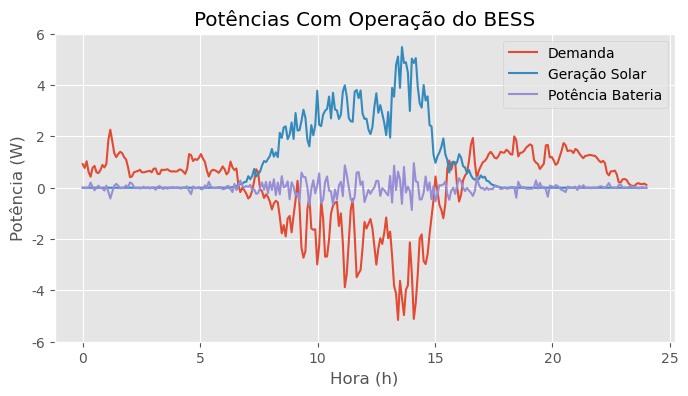

In [ ]:
horas = np.linspace(0,24,loop-1)
# plt.plot(horas,carga_kw-pv6_kw,label='Demand')
plt.plot(horas,-circuit_kw,label='Demanda')
# plt.axhline(Dmed,linestyle='--',color='g',label='Demanda Média')
# plt.plot(horas,gaussian_filter(circuit_kw,6),linestyle = '--',label='Gaussian-Filter')
plt.plot(horas,-pv6_kw,label='Geração Solar')
plt.plot(horas,bateria_kw,label='Potência Bateria')

# plt.plot(horas,losses_kw,label='Losses')
plt.title('Potências Com Operação do BESS')
plt.xlabel('Hora (h)')
plt.ylabel('Potência (W)')
plt.ylim(-6,6)
plt.legend(loc=1)


Comparação


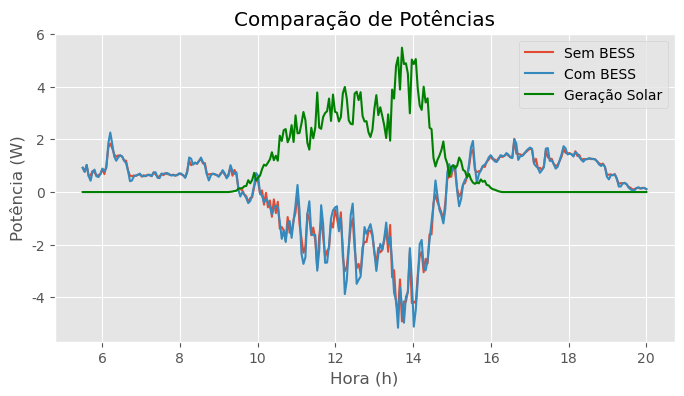

In [ ]:
horas = np.linspace(5.5,20,loop-1)
plt.plot(horas,-circuit_kw_SB,label='Sem BESS')
plt.plot(horas,-circuit_kw,label='Com BESS')
# plt.axhline(Dmed,linestyle='--',color='g',label='Demanda Média')
# plt.plot(horas,gaussian_filter(circuit_kw,6),linestyle = '--',label='Gaussian-Filter')
plt.plot(horas,-pv6_kw,label='Geração Solar',color='g')

# plt.plot(horas,losses_kw,label='Losses')
plt.title('Comparação de Potências')
plt.xlabel('Hora (h)')
plt.ylabel('Potência (W)')
plt.legend(loc=1)

Calculando o índice de suavização das curvas

Índice de Suavidade: 4.769016342748341


C:\Users\joao9\AppData\Local\Temp\ipykernel_546020\849486617.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


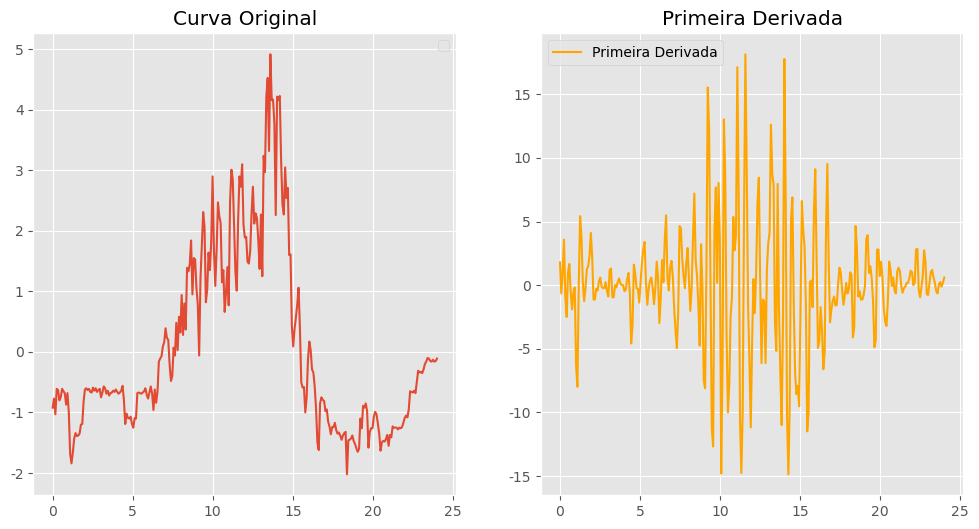

In [ ]:
# Dados de exemplo (curva)
x = np.linspace(0, 10, 100)
y = np.sin(x)  # Curva suave
# y = np.sin(x) + np.random.normal(0, 0.5, x.size)  # Curva menos suave
# Calcular a primeira derivada
dy_dx = np.gradient(circuit_kw, horas)

# Medir a suavidade como a variação da derivada
indice_de_suavidade = np.std(dy_dx)

print(f"Índice de Suavidade: {indice_de_suavidade}")

# Plotando a curva e sua derivada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.title('Curva Original')
plt.legend()
plt.plot(horas,circuit_kw_SB,label='Sem BESS')
plt.subplot(1, 2, 2)
plt.plot(horas, dy_dx, label='Primeira Derivada', color='orange')
plt.title('Primeira Derivada')
plt.legend()

plt.show()


Índice de Suavidade (Segunda Derivada): 45.77762702350074


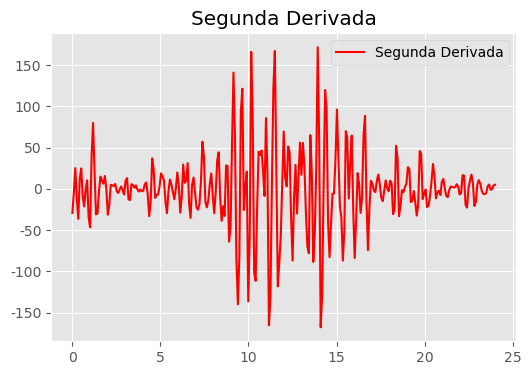

In [ ]:
# Calcular a segunda derivada
d2y_dx2 = np.gradient(dy_dx, horas)

# Medir a suavidade como a variação da segunda derivada
indice_de_suavidade_segunda = np.std(d2y_dx2)

print(f"Índice de Suavidade (Segunda Derivada): {indice_de_suavidade_segunda}")

# Plotando a segunda derivada
plt.figure(figsize=(6, 4))
plt.plot(horas, d2y_dx2, label='Segunda Derivada', color='red')
plt.title('Segunda Derivada')
plt.legend()
plt.show()
